# Determining the Best US Airport to Open a Clothing Store

## Make necessary imports

In [1036]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Use BeautifulSoup to crawl Wikipedia to determine list of busiest airports in US

In [1037]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States'
wiki_rawHTML = requests.get(wiki_url).text
wiki_content = BeautifulSoup(wiki_rawHTML, 'lxml')

In [1038]:
airports_table = wiki_content.find_all('table', class_="wikitable sortable")[0]
airports_table_rows = airports_table.find_all('tr')

## Save results in dictionary then convert to dataframe

In [1057]:
airports_dict = {}
keys = []
values = [[] for i in range(15)]

length = len(airports_table_rows)
for i in range(length):
    if (i == 0):
        headers = airports_table_rows[i].find_all('th')
        for header in headers:
            keys.append(header.text)
    else:
        cols = airports_table_rows[i].find_all('td')
        for i, colval in enumerate(cols):
            values[i].append(colval.text)

values
            
for i in range(len(keys)):
    airports_dict[keys[i]] = values[i]

In [1058]:
df = pd.DataFrame.from_dict(airports_dict)
df.drop(df.columns[[i for i in range(0, 3)] + [i for i in range(4, 8)] + [9, 13, 14]], inplace=True, axis=1)
df.head()

,2012[8],2017[3],Airports (large hubs),IATACode,Major city served
0,"45,798,809\n","50,251,962\n",Hartsfield–Jackson Atlanta International Airpo...,ATL\n,Atlanta\n
1,"31,326,268\n","41,232,416\n",Los Angeles International Airport\n,LAX\n,Los Angeles\n
2,"32,171,743\n","38,593,028\n",O'Hare International Airport\n,ORD\n,Chicago\n
3,"28,022,877\n","31,861,933\n",Dallas/Fort Worth International Airport\n,DFW\n,Dallas/Fort Worth\n
4,"25,799,832\n","29,809,091\n",Denver International Airport\n,DEN\n,Denver\n


## Clean the resulting dataframe extensively to produce results of passenger count for 2012 and 2017. This will be used to determine growth rate

In [1059]:
df.columns = ['2012', '2017', 'Name', 'IATA', 'City']
df = df.reindex(columns=['Name', 'City', 'IATA', '2012', '2017'])
df=df.replace('\n','', regex=True)
df['2012'] = df['2012'].replace(',', '', regex=True).astype(int)
df['2017'] = df['2017'].replace(',', '', regex=True).astype(int)
df.reset_index(inplace=True, drop=True)
df = df.replace('Gen. Edward Lawrence ', '', regex=True)
print("Dataframe shape: " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns")
df.head()

Dataframe shape: 30 rows and 5 columns


,Name,City,IATA,2012,2017
0,Hartsfield–Jackson Atlanta International Airport,Atlanta,ATL,45798809,50251962
1,Los Angeles International Airport,Los Angeles,LAX,31326268,41232416
2,O'Hare International Airport,Chicago,ORD,32171743,38593028
3,Dallas/Fort Worth International Airport,Dallas/Fort Worth,DFW,28022877,31861933
4,Denver International Airport,Denver,DEN,25799832,29809091


## Find latitude and longitutde of each airport using Geocoder

In [1060]:
def find_lat(loc):
    print(loc)
    try:
        return geocoder.osm(loc).osm['y']
    except:
        return 'Not Found'
    
def find_long(loc):
    print(loc)
    try:
        return geocoder.osm(loc).osm['x']
    except:
        return 'Not Found'

df['Latitude'] = df['Name'].apply(lambda x: find_lat(x))
df['Longitude'] = df['Name'].apply(lambda x: find_long(x))

Hartsfield–Jackson Atlanta International Airport
Los Angeles International Airport
O'Hare International Airport
Dallas/Fort Worth International Airport
Denver International Airport
John F. Kennedy International Airport
San Francisco International Airport
McCarran International Airport
Seattle–Tacoma International Airport
Charlotte Douglas International Airport
Newark Liberty International Airport
Orlando International Airport
Phoenix Sky Harbor International Airport
Miami International Airport
George Bush Intercontinental Airport
Logan International Airport
Minneapolis–Saint Paul International Airport
Detroit Metropolitan Airport
Fort Lauderdale–Hollywood International Airport
Philadelphia International Airport
LaGuardia Airport
Baltimore–Washington International Airport
Salt Lake City International Airport
Ronald Reagan Washington National Airport
Washington Dulles International Airport
San Diego International Airport
Midway International Airport
Tampa International Airport
Daniel K. 

In [1061]:
df

,Name,City,IATA,2012,2017,Latitude,Longitude
0,Hartsfield–Jackson Atlanta International Airport,Atlanta,ATL,45798809,50251962,33.6378,-84.4293
1,Los Angeles International Airport,Los Angeles,LAX,31326268,41232416,33.9422,-118.421
2,O'Hare International Airport,Chicago,ORD,32171743,38593028,41.978,-87.9093
3,Dallas/Fort Worth International Airport,Dallas/Fort Worth,DFW,28022877,31861933,32.8965,-97.0465
4,Denver International Airport,Denver,DEN,25799832,29809091,39.8502,-104.675
5,John F. Kennedy International Airport,New York,JFK,24520943,29533154,40.6429,-73.7794
6,San Francisco International Airport,San Francisco,SFO,21284224,26900016,37.6225,-122.384
7,McCarran International Airport,Las Vegas,LAS,19941173,23364185,36.0861,-115.161
8,Seattle–Tacoma International Airport,Seattle/Tacoma,SEA,16625787,22639120,47.4476,-122.308
9,Charlotte Douglas International Airport,Charlotte,CLT,20032426,22011225,35.2107,-80.9457


## Calculate the growth rate

In [1065]:
def growthrate(row):
    return round(((row['2017'] - row['2012']) / row['2012']) * 100, 2)
df = df[df['Longitude']!='Not found']
df['Growth'] = df.apply(lambda row: growthrate(row), axis=1)
df = df[df['Growth'] > 10]
df.head()

,Name,City,IATA,2012,2017,Latitude,Longitude,Growth
1,Los Angeles International Airport,Los Angeles,LAX,31326268,41232416,33.9422,-118.421,31.62
2,O'Hare International Airport,Chicago,ORD,32171743,38593028,41.978,-87.9093,19.96
3,Dallas/Fort Worth International Airport,Dallas/Fort Worth,DFW,28022877,31861933,32.8965,-97.0465,13.70
4,Denver International Airport,Denver,DEN,25799832,29809091,39.8502,-104.675,15.54
5,John F. Kennedy International Airport,New York,JFK,24520943,29533154,40.6429,-73.7794,20.44


## Plot all results on map, with size of circle determining size of airport and color determining growth rate

In [1066]:
def find_color(growth):
    if (growth > 30):
        return 'red'
    if (growth > 20):
        return 'orange'
    else:
        return 'yellow'

map_clusters = folium.Map(location=[37, -93], zoom_start=4)

for lat, long, pop, growth in zip(df['Latitude'], df['Longitude'], df['2017'], df['Growth']):
    folium.CircleMarker(
    [lat, long],
    color='black',
    weight=1,
    fill_color=find_color(growth),
    fill_opacity=0.6,
    radius=pop/2000000).add_to(map_clusters)

map_clusters

## Specify foursquare credentials and parameters for url. We will make use of the search endpoint.

In [1073]:
CLIENT_ID = 'N0M3U3CG1U2U4TLPUWXXQ101ITC4Y3VRNXWLHYWBP21M0UPC'
CLIENT_SECRET = '4HFZ2AIBI1VN4AFP1HKGZ0YC4AMEARDKSZ0FXCTNXZ1TVHMS'
categoryid ='4bf58dd8d48988d103951735'

VERSION = 20180602

LIMIT= 200

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&categoryId={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            categoryid,
            VERSION, 
            47, 
            54, 
            1000, 
            LIMIT)
            
        # make the GET request
requests.get(url).json()["response"]

{}

## Make the funciton which will get a list of all clothing store venues for each location

In [1068]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&categoryId={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            categoryid,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        for v in range(len(results)):
            venue = results[v]
            venues_list.append([(
                name,
                lat,
                lng,
                venue['name'],
                venue['location']['lat'], 
                venue['location']['lng'],  
                venue['categories'][0]['name']) 
            ])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Airport', 
                  'Airport Latitude', 
                  'Airport Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [1110]:
airport_venues = getNearbyVenues(df['Name'], df['Latitude'], df['Longitude'])
airport_venues.head()

Los Angeles International Airport
O'Hare International Airport
Dallas/Fort Worth International Airport
Denver International Airport
John F. Kennedy International Airport
San Francisco International Airport
McCarran International Airport
Seattle–Tacoma International Airport
Newark Liberty International Airport
Orlando International Airport
Logan International Airport
Minneapolis–Saint Paul International Airport
Detroit Metropolitan Airport
Fort Lauderdale–Hollywood International Airport
LaGuardia Airport
Baltimore–Washington International Airport
Salt Lake City International Airport
Ronald Reagan Washington National Airport
San Diego International Airport
Midway International Airport
Tampa International Airport
Portland International Airport


,Airport,Airport Latitude,Airport Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Los Angeles International Airport,33.942168,-118.421376,Gucci,33.943150,-118.410340,Boutique
1,Los Angeles International Airport,33.942168,-118.421376,Salvatore Ferragamo,33.943449,-118.409170,Shoe Store
2,Los Angeles International Airport,33.942168,-118.421376,Fred Segal,33.942870,-118.410305,Boutique
3,Los Angeles International Airport,33.942168,-118.421376,Michael Kors,33.943220,-118.410312,Boutique
4,Los Angeles International Airport,33.942168,-118.421376,Emperio Armani,33.943867,-118.410063,Clothing Store


## Determine the most popular store categories

In [1055]:
df_count = airport_venues.groupby('Venue Category').count()[['Airport']].sort_values(by='Airport', ascending=False).head(10)

df_count['Venue Category'] = df_count.index
df_count.rename(columns={'Airport': 'Count'}, inplace=True)
df_count = df_count[['Venue Category', 'Count']]
df_count.index = range(0, 10)
df_count


,Venue Category,Count
0,Clothing Store,148
1,Boutique,81
2,Accessories Store,76
3,Shoe Store,54
4,Women's Store,44
5,Men's Store,33
6,Lingerie Store,11
7,Department Store,9
8,Gift Shop,7
9,Sporting Goods Shop,6


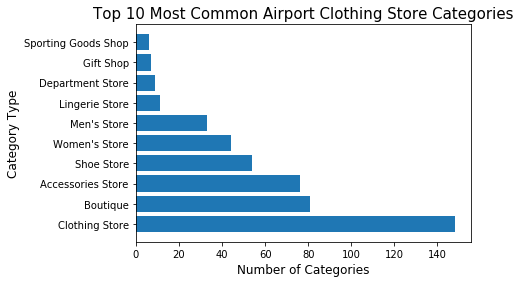

In [979]:
index = np.arange(len(df_count['Venue Category']))
plt.barh(index, df_count['Count'])
plt.xlabel('Number of Categories', fontsize=12)
plt.ylabel('Category Type', fontsize=12)
plt.yticks(index, df_count['Venue Category'], fontsize=10)
plt.title('Top 10 Most Common Airport Clothing Store Categories', fontsize=15)
plt.show()

## Determine number of stores per airport

In [992]:
ratio = airport_venues.groupby('Airport').count()
ratio.drop(ratio.columns[[1,2,3,4,5]], axis=1, inplace=True)
ratio.columns =['Store Count']
ratio = ratio.sort_values(by='Store Count', ascending=False)
ratio

,Store Count
Airport,
Tampa International Airport,50
Ronald Reagan Washington National Airport,50
McCarran International Airport,48
San Diego International Airport,42
John F. Kennedy International Airport,35
Dallas/Fort Worth International Airport,31
Los Angeles International Airport,28
San Francisco International Airport,22
LaGuardia Airport,22


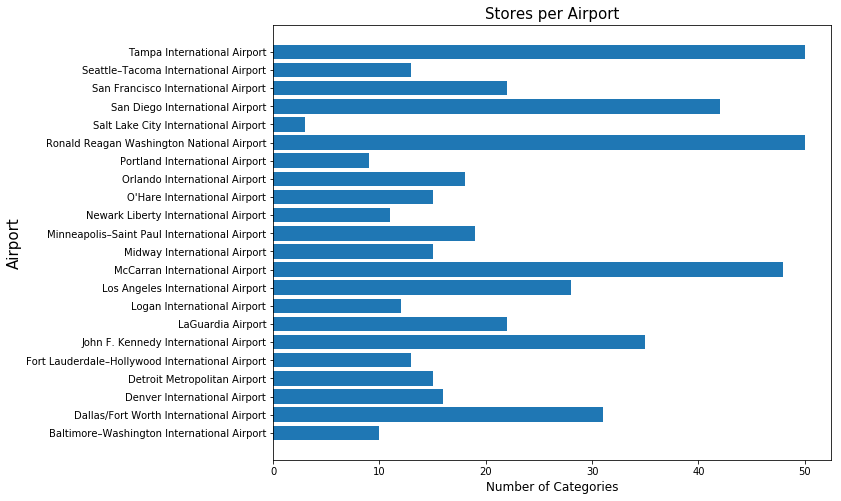

In [1074]:
plt.figure(figsize=(10,8))
plt.barh(ratio.index, ratio['Store Count'])
plt.xlabel('Number of Categories', fontsize=12)
plt.ylabel('Airport', fontsize=15)
plt.title('Stores per Airport', fontsize=15)
plt.show()

## Add column for ratio of passengers to stores for each airport

In [994]:
df_growthratio = pd.merge(ratio, df, left_index=True, right_on='Name')
df_growthratio['Ratio'] = round(df_growthratio['2017']/df_growthratio['Store Count'])
df_growthratio = df_growthratio[['Name', 'City', 'Growth', 'Ratio']]
df_growthratio = df_growthratio.reset_index(drop=True)
df_growthratio['City'] = df_final['City'].apply(lambda x: x.split('/')[0])
df_growthratio = df_growthratio.replace(', D.C.', '', regex=True)
df_growthratio.head()

,Name,City,Growth,Ratio
0,Tampa International Airport,Baltimore,19.65,196612.0
1,Ronald Reagan Washington National Airport,Dallas,26.46,239327.0
2,McCarran International Airport,Denver,17.17,486754.0
3,San Diego International Airport,Detroit,27.86,264454.0
4,John F. Kennedy International Airport,Fort Lauderdale,20.44,843804.0


## Use BeautifulSoup again to crawl Wikipedia page for income of US metropolitan areas

In [995]:
income_url = 'https://en.wikipedia.org/wiki/List_of_United_States_metropolitan_areas_by_per_capita_income'
income_rawHTML = requests.get(income_url).text
income_content = BeautifulSoup(income_rawHTML, 'lxml')

income_table = income_content.find('table', class_="toccolours sortable")
income_table_rows = income_table.find_all('tr')

In [996]:
income_dict = {}
i_keys = []
i_values = [[] for i in range(15)]

length = len(income_table_rows)
for i in range(length):
    if (i == 0):
        headers = income_table_rows[i].find_all('th')
        for header in headers:
            i_keys.append(header.text)
    else:
        cols = income_table_rows[i].find_all('td')
        for i, colval in enumerate(cols):
            i_values[i].append(colval.text)

values
            
for i in range(len(i_keys)):
    income_dict[i_keys[i]] = i_values[i]

In [997]:
df_income = pd.DataFrame.from_dict(income_dict)
df_income.drop(df_income.columns[[2, 3]], axis=1, inplace=True)
df_income.columns = ['Metro', 'Income']
df_income = df_income.replace(['\$', ',', '\n'], '', regex=True)
df_income['Metro'] = df_income['Metro'].apply(lambda x: x.split('–')[0])
df_income['Metro'] = df_income['Metro'].apply(lambda x: x.split('-')[0])
df_income['Income'] = df_income['Income'].astype(int)
print("Unfiltered dataframe has " + str(df_income.shape[0]) + " rows")
df_income.head()

Unfiltered dataframe has 280 rows


,Metro,Income
0,Washington,47411
1,San Jose,40392
2,Seattle,39322
3,San Francisco,38355
4,Boston,37311


## Filter our dataframe to only contain cities within our original dataframe

In [1081]:
df_income = pd.DataFrame(columns=df_income.columns)

for city in df_final['City']:
    row = df_income[df_income['Metro'].str.contains(city)].head(1)
    df_income = dftest.append(row, ignore_index=True)
    
df_income= df_income.replace([' Florida MSA', ' California MSA', ' Nevada'], '', regex=True)

print("Filtered dataframe has " + str(df_income.shape[0]) + " rows")
df_income.head()

Filtered dataframe has 20 rows


,Metro,Income
0,Baltimore,29771
1,Dallas,23616
2,Denver,32399
3,Detroit,22319
4,New York,24581


## There are several null values within the dataframe...

In [1082]:
df_total = pd.merge(left=df_final, right=df_income, how='left', left_on='City', right_on='Metro')
df_total[df_total['Income'].isnull()]

,Name,City,Growth,Ratio,Metro,Income
4,Fort Lauderdale–Hollywood International Airport,Fort Lauderdale,41.69,1247437.0,NaN,NaN
14,Midway International Airport,Chicago,15.69,727465.0,NaN,NaN
19,O'Hare International Airport,Chicago,19.96,2572869.0,NaN,NaN


## Manually add these values through a quick Google search to determine income

In [1083]:
df_total.loc[df_total['City'] == 'Chicago', 'Income'] = 32258
df_total.loc[df_total['City'] == 'Fort Lauderdale', 'Income'] = 35828
df_total.drop(['Metro'], inplace=True, axis=1)
df_total = df_total.drop_duplicates()
df_total = df_total.reset_index(drop=True)
df_total

,Name,City,Growth,Ratio,Income
0,Baltimore–Washington International Airport,Baltimore,18.15,1321418.0,29771
1,Dallas/Fort Worth International Airport,Dallas,13.70,1027804.0,23616
2,Denver International Airport,Denver,15.54,1863068.0,32399
3,Detroit Metropolitan Airport,Detroit,11.06,1155040.0,22319
4,Fort Lauderdale–Hollywood International Airport,Fort Lauderdale,41.69,1247437.0,35828
5,John F. Kennedy International Airport,New York,20.44,843804.0,24581
6,LaGuardia Airport,New York,14.97,669902.0,24581
7,Logan International Airport,Boston,33.94,1595425.0,37311
8,Los Angeles International Airport,Los Angeles,31.62,1472586.0,21170
9,McCarran International Airport,Las Vegas,17.17,486754.0,21210


# Now we normalize all values and obtain our dataframe ready for K-means clustering

In [1007]:
df_total['Income'] = df_total['Income'].astype(int)
df_total['Ratio'] = df_total['Ratio'].astype(int)


df_total['Growth'] = ((df_total['Growth'] - df_total['Growth'].mean())/df_total['Growth'].std(ddof=0))
df_total['Ratio'] = ((df_total['Ratio'] - df_total['Ratio'].mean())/df_total['Ratio'].std(ddof=0))
df_total['Income'] = ((df_total['Income'] - df_total['Income'].mean())/df_total['Income'].std(ddof=0))

df_total

,Name,City,Growth,Ratio,Income
0,Baltimore–Washington International Airport,Baltimore,-0.698716,0.063611,0.069118
1,Dallas/Fort Worth International Airport,Dallas,-1.257255,-0.287276,-0.781181
2,Denver International Airport,Denver,-1.026308,0.710916,0.432170
3,Detroit Metropolitan Airport,Detroit,-1.588613,-0.135221,-0.960358
4,Fort Lauderdale–Hollywood International Airport,Fort Lauderdale,2.255893,-0.024801,0.905878
5,John F. Kennedy International Airport,New York,-0.411288,-0.507167,-0.647868
6,LaGuardia Airport,New York,-1.097852,-0.714990,-0.647868
7,Logan International Airport,Boston,1.283156,0.391066,1.110751
8,Los Angeles International Airport,Los Angeles,0.991963,0.244266,-1.119090
9,McCarran International Airport,Las Vegas,-0.821720,-0.933864,-1.113564


## First, we can investigate relationship between income and 5 year growth rate

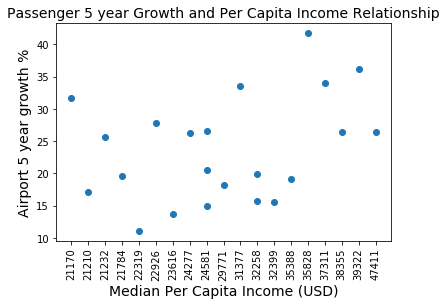

In [1116]:
from scipy import stats

plt.scatter(df_total['Income'], df_total['Growth'])
plt.xlabel('Median Per Capita Income (USD)', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Airport 5 year growth %', fontsize=14)
plt.title('Passenger 5 year Growth and Per Capita Income Relationship', fontsize=14)
plt.show()

## Additionally, investigate income between Income and ratio of passengers:clothing store venues. Limited correlation found here

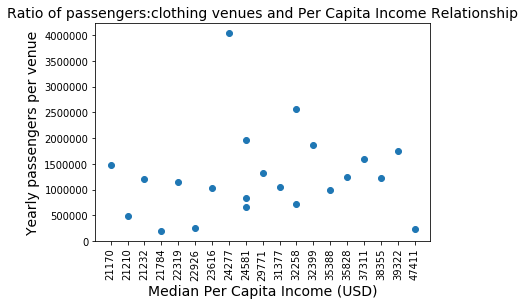

In [1119]:
plt.scatter(df_total['Income'], df_total['Ratio'])
plt.xlabel('Median Per Capita Income (USD)', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Yearly passengers per venue', fontsize=14)
plt.title('Ratio of passengers:clothing venues and Per Capita Income Relationship', fontsize=14)
plt.show()

## Use Elbow graph to determine best value of k=6

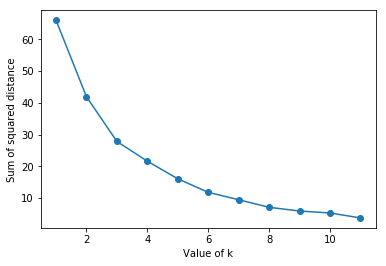

In [1008]:
sse =[]
list_k = list(range(1,12))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(clustering_df)
    sse.append(km.inertia_)


plt.plot(list_k, sse, '-o')
plt.xlabel('Value of k')
plt.ylabel('Sum of squared distance');

## Use k=6 to make model for clustering and obtain labels

In [1009]:
k = 6
clustering_df = df_total.drop(['Name', 'City'], axis=1)

kmeans_clustering = KMeans(n_clusters=k, random_state=4).fit(clustering_df)
kmeans_clustering.labels_

array([1, 5, 1, 5, 2, 5, 5, 2, 0, 5, 5, 1, 0, 1, 0, 2, 3, 4, 0, 2, 2, 5])

## Assign cluster labels to airports in dataframe

In [1010]:
df_total['Cluster'] = kmeans_clustering.labels_
df_total.head()

,Name,City,Growth,Ratio,Income,Cluster
0,Baltimore–Washington International Airport,Baltimore,-0.698716,0.063611,0.069118,1
1,Dallas/Fort Worth International Airport,Dallas,-1.257255,-0.287276,-0.781181,5
2,Denver International Airport,Denver,-1.026308,0.710916,0.432170,1
3,Detroit Metropolitan Airport,Detroit,-1.588613,-0.135221,-0.960358,5
4,Fort Lauderdale–Hollywood International Airport,Fort Lauderdale,2.255893,-0.024801,0.905878,2


## Determine statistics for each cluster: looking for highest mean values of growth, ratio and income.

In [1011]:
df_mean = df_total.loc[: , "Growth":"Income"]

df_mean['Mean'] = df_mean.mean(axis=1)
df_mean['Cluster'] = df_total['Cluster']
df_mean = df_mean.drop(['Growth', 'Ratio', 'Income'], axis=1)
df_mean = df_mean.groupby(by='Cluster').mean()
df_mean

,Mean
Cluster,
0,-0.153418
1,0.083869
2,0.816601
3,0.540265
4,0.979053
5,-0.760590


In [1015]:
df_total = df_total.sort_values(by='Cluster').reset_index(drop=True)
df_total

,Name,City,Growth,Ratio,Income,Cluster
0,San Diego International Airport,San Diego,0.520029,-1.199526,-0.876503,0
1,Los Angeles International Airport,Los Angeles,0.991963,0.244266,-1.119090,0
2,Newark Liberty International Airport,New York,0.365646,0.827973,-0.647868,0
3,Orlando International Airport,Orlando,0.246408,-0.083785,-1.110525,0
4,Baltimore–Washington International Airport,Baltimore,-0.698716,0.063611,0.069118,1
5,Denver International Airport,Denver,-1.026308,0.710916,0.432170,1
6,Minneapolis–Saint Paul International Airport,Minneapolis,-0.569436,-0.320343,0.845093,1
7,O'Hare International Airport,Chicago,-0.471535,1.559172,0.412691,1
8,Seattle–Tacoma International Airport,Seattle,1.563053,0.565600,1.388566,2
9,Portland International Airport,Portland,1.232951,-0.249003,0.290983,2


## Since cluster 4 had highest values, Salt lake City was determined to be best choice

In [972]:
df_total[df_total['Cluster'] == 4]

,Name,City,Growth,Ratio,Income,Cluster
17,Salt Lake City International Airport,Salt Lake City,0.322971,3.304053,-0.689865,4


## Plot resulting clusters on a map

In [1019]:
dftotal = pd.merge(left=df_total, right=df, how='left', left_on='Name', right_on='Name')

In [1025]:
def find_color(cluster):
    if (cluster == 0):
        return 'red'
    if (cluster == 1):
        return 'orange'
    if (cluster == 2):
        return 'yellow'
    if (cluster == 3):
        return 'greem'
    if (cluster == 4):
        return 'blue'
    else:
        return 'purple'

map_clusters = folium.Map(location=[37, -93], zoom_start=4)

for lat, long, cluster in zip(dftotal['Latitude'], dftotal['Longitude'], dftotal['Cluster']):
    folium.CircleMarker(
    [lat, long],
    color='black',
    weight=1,
    fill_color=find_color(cluster),
    fill_opacity=0.6,
    radius=pop/2000000).add_to(map_clusters)

map_clusters